In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files

%load_ext autoreload
%autoreload 2

In [2]:
TUM_colors =  {
    "TUMBlue": "#0065BD",
    "TUMSecondaryBlue": "#005293",
    "TUMSecondaryBlue2": "#003359",
    "TUMBlack": "#000000",
    "TUMWhite": "#FFFFFF",
    "TUMDarkGray": "#333333",
    "TUMGray": "#808080",
    "TUMLightGray": "#CCCCC6",
    "TUMAccentGray": "#DAD7CB",
    "TUMAccentOrange": "#E37222",
    "TUMAccentGreen": "#A2AD00",
    "TUMAccentLightBlue": "#98C6EA",
    "TUMAccentBlue": "#64A0C8"
}

In [3]:
BASE_DIR = "/home/getznerj/Documents/Thesis/Thesis Final Experiments"

In [4]:
def plot_data(
        data,
        log_dir,
        secondary_color_at=None,
        secondary_color_legend_text="",
        override_insignificance=False,
        legend_outside=False
):
    # split data into two dicts, one where keys contain nonDP and the others
    data_nonDP = {key: dataset for key, dataset in data.items() if "noDP" in key}
    data_DP = {key: dataset for key, dataset in data.items() if "noDP" not in key}
    # order dicts by key
    data_nonDP = {k: data_nonDP[k] for k in sorted(data_nonDP)}
    data_DP = {k: data_DP[k] for k in sorted(data_DP)}
    for data_dict in [data_nonDP,data_DP]:
        for idx, (df_name, df) in enumerate(data_dict.items()):
            fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
            fontSize = 11
            rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.6}
            plt.rcParams.update(rc)
            pv = "age" if "age" in df_name else "sex"
            metrics = [col for col in df.columns if "subgroupAUROC" in col]
            df = df[["protected_attr", "protected_attr_percent", "seed"] + metrics]
            df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
            protected_attrs_to_plot = [np.round(k,2) for k in np.arange(0, 1.1, 0.1)] + [0.25,0.75]
            df = df.loc[df["protected_attr_percent"].isin(protected_attrs_to_plot)]
            metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
            g = plot_runs(df, metrics, pv, secondary_color_at=secondary_color_at, secondary_color_legend_text=secondary_color_legend_text, override_insignificance=override_insignificance, ax=axes, font_size=fontSize, legend_outside=legend_outside)
            # remove x label if idx == 0
            plt.tight_layout()
            plt.show()
            fig.savefig(f"../plots/{log_dir}/{pv}_{'DP' if not 'noDP' in df_name else 'no-DP'}.png", bbox_inches="tight")

In [5]:
def compute_performance_gaps(data):
    for df_name, df in data.items():
        metrics = [col for col in df.columns if "subgroupAUROC" in col]
        pv = "age" if "age" in df_name else "sex"
        dp = False if "noDP" in df_name else True
        df_temp = df[["protected_attr", "protected_attr_percent"] + [col for col in df.columns if "subgroupAUROC" in col]]
        # compute mean performance at each protected attribute percentage
        df_temp = df_temp.groupby(["protected_attr","protected_attr_percent"]).mean().reset_index()
        df_temp = df_temp.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
        df_temp["performance_gap"] = abs(df_temp[PV_MAP[pv][1]] - df_temp[PV_MAP[pv][0]])*100
        # print(f"{'DP' if dp else 'No-DP'}: Mean performance gap for {pv}: {df_temp['performance_gap'].mean()}")
        print(f"{'DP' if dp else 'No-DP'} with {pv}:")
        print("worst case performance gap: ", df_temp["performance_gap"].max())
        print("mean performance gap: ", df_temp["performance_gap"].mean())


# Baseline

In [ ]:
log_dir = os.path.join(BASE_DIR, "baseline")
data = load_logs(log_dir = log_dir)

In [ ]:
plot_data(data, "baseline")

In [ ]:
compute_performance_gaps(data)

# Up-Sampling

In [ ]:
log_dir = os.path.join(BASE_DIR, "upsampling")
data = load_logs(log_dir = log_dir)
data = add_values_from_normal_runs(BASE_DIR, data, 0.5)

In [ ]:
plot_data(data, log_dir="upsampling", secondary_color_at=50, secondary_color_legend_text="balanced - no upsampling")

In [ ]:
compute_performance_gaps(data)

# Loss Weighting

In [ ]:
log_dir = os.path.join(BASE_DIR, "loss_weighing")
data = load_logs(log_dir = log_dir)

In [ ]:
def get_values_from_normal_runs(data_outer, split):
    data_normal = load_logs(log_dir = os.path.join(BASE_DIR, "baseline"))
    new_rows = {}
    for key, df_normal in data_normal.items():
        pv = "age" if "age" in key else "sex"
        dp = False if "noDP" in key else True
        corresponding_outer_keys = [k for k in data_outer.keys() if pv in k and ((not dp) == ("noDP" in k))]
        if corresponding_outer_keys == []:
            continue
        else:
            corresponding_outer_key = corresponding_outer_keys[0]
        rows = df_normal[df_normal["protected_attr_percent"] == split]
        new_rows[corresponding_outer_key] = rows
    return new_rows

In [ ]:
data_weight_1 = get_values_from_normal_runs(data, 0.5)
for key, dataset in data_weight_1.items():
    dataset["weight"] = 1
    data[key] = pd.concat([data[key], dataset])

In [ ]:
for key, dataset in data.items():
    fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
    font_size = 11
    rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': font_size, 'axes.titlesize': font_size, 'font.size': font_size, 'legend.fontsize': font_size*0.8}
    plt.rcParams.update(rc)
    dataset = dataset.loc[dataset["protected_attr_percent"] == 0.5]
    pv = "age" if "age" in key else "sex"
    metrics = [col for col in dataset.columns if "subgroupAUROC" in col]
    df = dataset[["protected_attr", "protected_attr_percent", "seed", "weight"] + metrics]
    # rename metrics
    df = df.rename(columns={metric: PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics})
    metrics = [PV_MAP[pv][1] if PV_MAP[pv][1] in metric else PV_MAP[pv][0] for metric in metrics]
    axes = plot_runs(
        df,
        metrics,
        pv,
        secondary_color_at=1.0,
        secondary_color_legend_text="no weighing",
        x_var="weight",
        regress=False,
        ax=axes,
        font_size=font_size*0.8,
        ylim=0,
        legend_outside=True
    )
    fig.savefig(f"../plots/loss_weighing/{pv}_{'DP' if not 'noDP' in key else 'no-DP'}.png", bbox_inches="tight")

# Fine-Tuning

In [ ]:
log_dir = os.path.join(BASE_DIR, "fine_tuning")
data = load_logs(log_dir = log_dir)

In [ ]:
plot_data(data,log_dir="fine_tuning", override_insignificance=True, legend_outside=True)

# Core Set Selection

In [108]:
from matplotlib.font_manager import fontManager, FontProperties
path = "/home/getznerj/Downloads/Palatino Font Free/Palatino.ttf"
fontManager.addfont(path)
prop = FontProperties(fname=path)
plt.rcParams['font.family'] = prop.get_name()

In [109]:
font_size = 11
rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': font_size, 'axes.titlesize': font_size, 'font.size': font_size, 'legend.fontsize': font_size*0.8}
plt.rcParams.update(rc)

In [110]:
from matplotlib.lines import Line2D
metrics = (
    f"test/old_subgroupAUROC", f"test/young_subgroupAUROC",
    f"test/female_subgroupAUROC", f"test/male_subgroupAUROC"
)

In [111]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        score_var = d.split("/")[-1].split("-")[0]
        dp = not "noDP" in d
        if dp:
            num_samples = int(d.split("/")[-1].split("-")[-1].split("_")[0])
        else:
            num_samples = int(d.split("/")[-1].split("-")[-1])
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')]
            for results_dir in results:
                results_df = pd.read_csv(os.path.join(d, seed, results_dir))
                results_df["score_var"] = score_var
                results_df["num_samples"] = num_samples
                dfs.append(results_df)
    return pd.concat(dfs, ignore_index=True)

In [112]:
data_noDP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-11-09 20:06:05-FAE-rsna-balanced-subsetperformance-noDP/old_percent_05_bestBytest"))
data_noDP = data_noDP.loc[data_noDP.dataset == "rsna"]
data_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-07 16:22:58-FAE-rsna-balanced-subsetperformance-DP/old_percent_05_bestBytest"))
data_age_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-08 14:17:02-FAE-rsna-old-age-subsetperformance-DP/old_percent_05_bestBytest"))
data_sex_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-08 15:57:52-FAE-rsna-old-sex-subsetperformance-DP/male_percent_05_bestBytest"))

In [113]:
plot_settings = {
    (0,0):  ("-",TUM_colors["TUMAccentBlue"]), 
    (0,1):  ("-",TUM_colors["TUMAccentOrange"]),
    (1,0):  ("--",TUM_colors["TUMAccentBlue"]), 
    (1,1):  ("--",TUM_colors["TUMAccentOrange"]),
}

In [114]:
def plot_coresetselection(df_core_set, dp=False):
    for pv in ["age", "sex"]:
        if pv == "age":
            score_vars = ["old_subgroupAUROC", "young_subgroupAUROC"]
            metrics = ["old", "young"]
        else:
            score_vars = ["male_subgroupAUROC", "female_subgroupAUROC"]
            metrics = ["male", "female"]
        fig, axes = plt.subplots(1, 1, figsize=(5.78853, 3), sharey="row", sharex="col")
        legend_elements = []
        for a, score_var in enumerate(score_vars):
            for b, metric in enumerate(metrics):
                data = df_core_set.loc[(df_core_set.score_var == score_var) & (df_core_set.metric == metric)]
                # print mean and std of each line
                # only 50 samples
                temp = data.loc[data.num_samples == 50]
                print(score_var)
                print(f"mean {metric}-AUC: {temp.value.mean()}", f"std {metric}-AUC: {temp.value.std()}")
                g = sns.lineplot(
                    data=data,
                    x="num_samples",
                    y="value",
                    color=plot_settings[(a,b)][1],
                    ls=plot_settings[(a,b)][0],
                    ax=axes
                )
                if "female" in score_var:
                    metric_name = "female"
                elif "young" in score_var:
                    metric_name = "young"
                elif "old" in score_var:
                    metric_name = "old"
                else:
                    metric_name = "male"
                legend_elements.append(Line2D([0], [0], color=plot_settings[(a,b)][1], linestyle=plot_settings[(a,b)][0], label=f"{metric} (best {metric_name})"))
            axes.legend(handles=legend_elements, title='Group', bbox_to_anchor=(1.0, 1.02), loc='upper left')    

            #axes.set_title(f"best samples by {metric_name}-AUC")
            axes.set_ylabel("s-AUC")
            axes.set_xlabel("Number of Samples")
        plt.show()
        fig.savefig(f"../plots/core-set-selection/{pv}_{'no-DP' if not dp else 'DP'}.png", bbox_inches="tight")

# NoDP

In [115]:
data_noDP = data_noDP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_noDP = data_noDP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")

In [116]:
data_noDP = data_noDP.loc[data_noDP["score_var"] != "AUROC"]
data_noDP.metric = data_noDP.metric.str.replace("test/", "")
data_noDP.metric = data_noDP.metric.str.replace("_subgroupAUROC", "")

old_subgroupAUROC
mean old-AUC: 0.7474449872970581 std old-AUC: 0.0032024614578156614
old_subgroupAUROC
mean young-AUC: 0.6028249979019165 std young-AUC: 0.002682885133451012
young_subgroupAUROC
mean old-AUC: 0.7188949942588806 std old-AUC: 0.006727865252477609
young_subgroupAUROC
mean young-AUC: 0.6724699914455414 std young-AUC: 0.005093318087086947


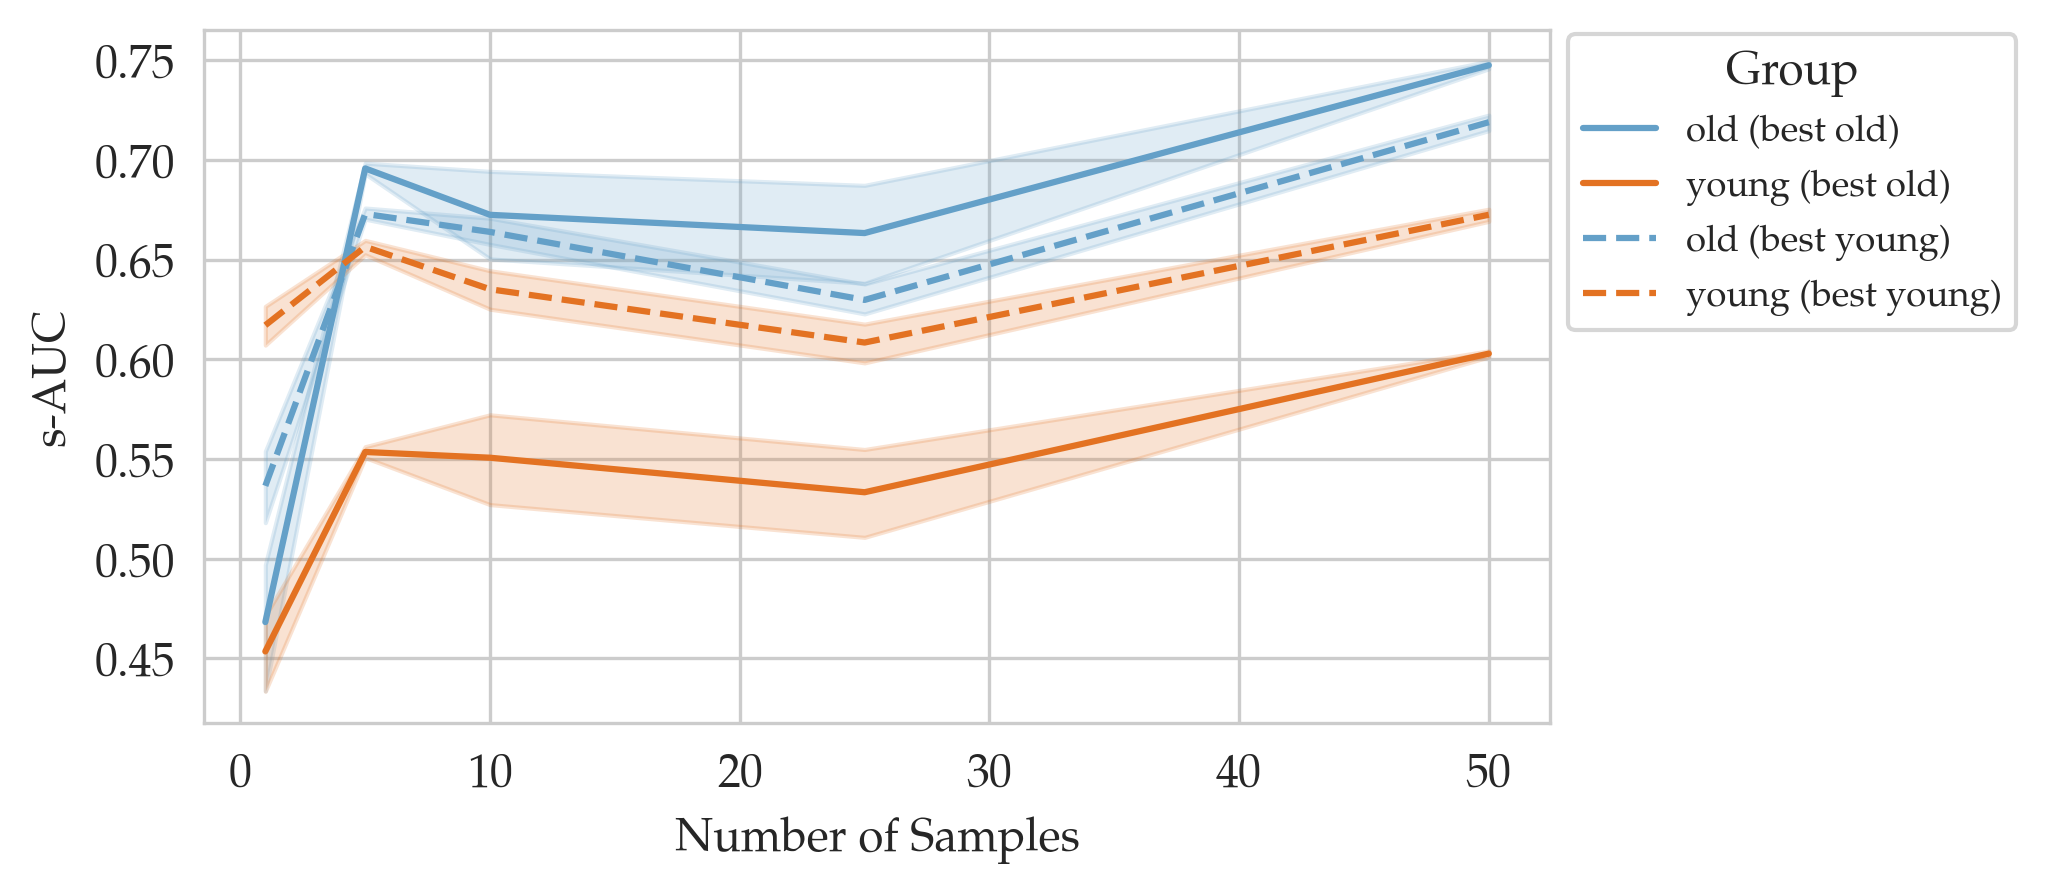

male_subgroupAUROC
mean male-AUC: 0.7779875159263611 std male-AUC: 0.0037374866362737576
male_subgroupAUROC
mean female-AUC: 0.5656999886035919 std female-AUC: 0.005626820223212822
female_subgroupAUROC
mean male-AUC: 0.7322700023651123 std male-AUC: 0.004323407387753626
female_subgroupAUROC
mean female-AUC: 0.6579350054264068 std female-AUC: 0.0043633110635058255


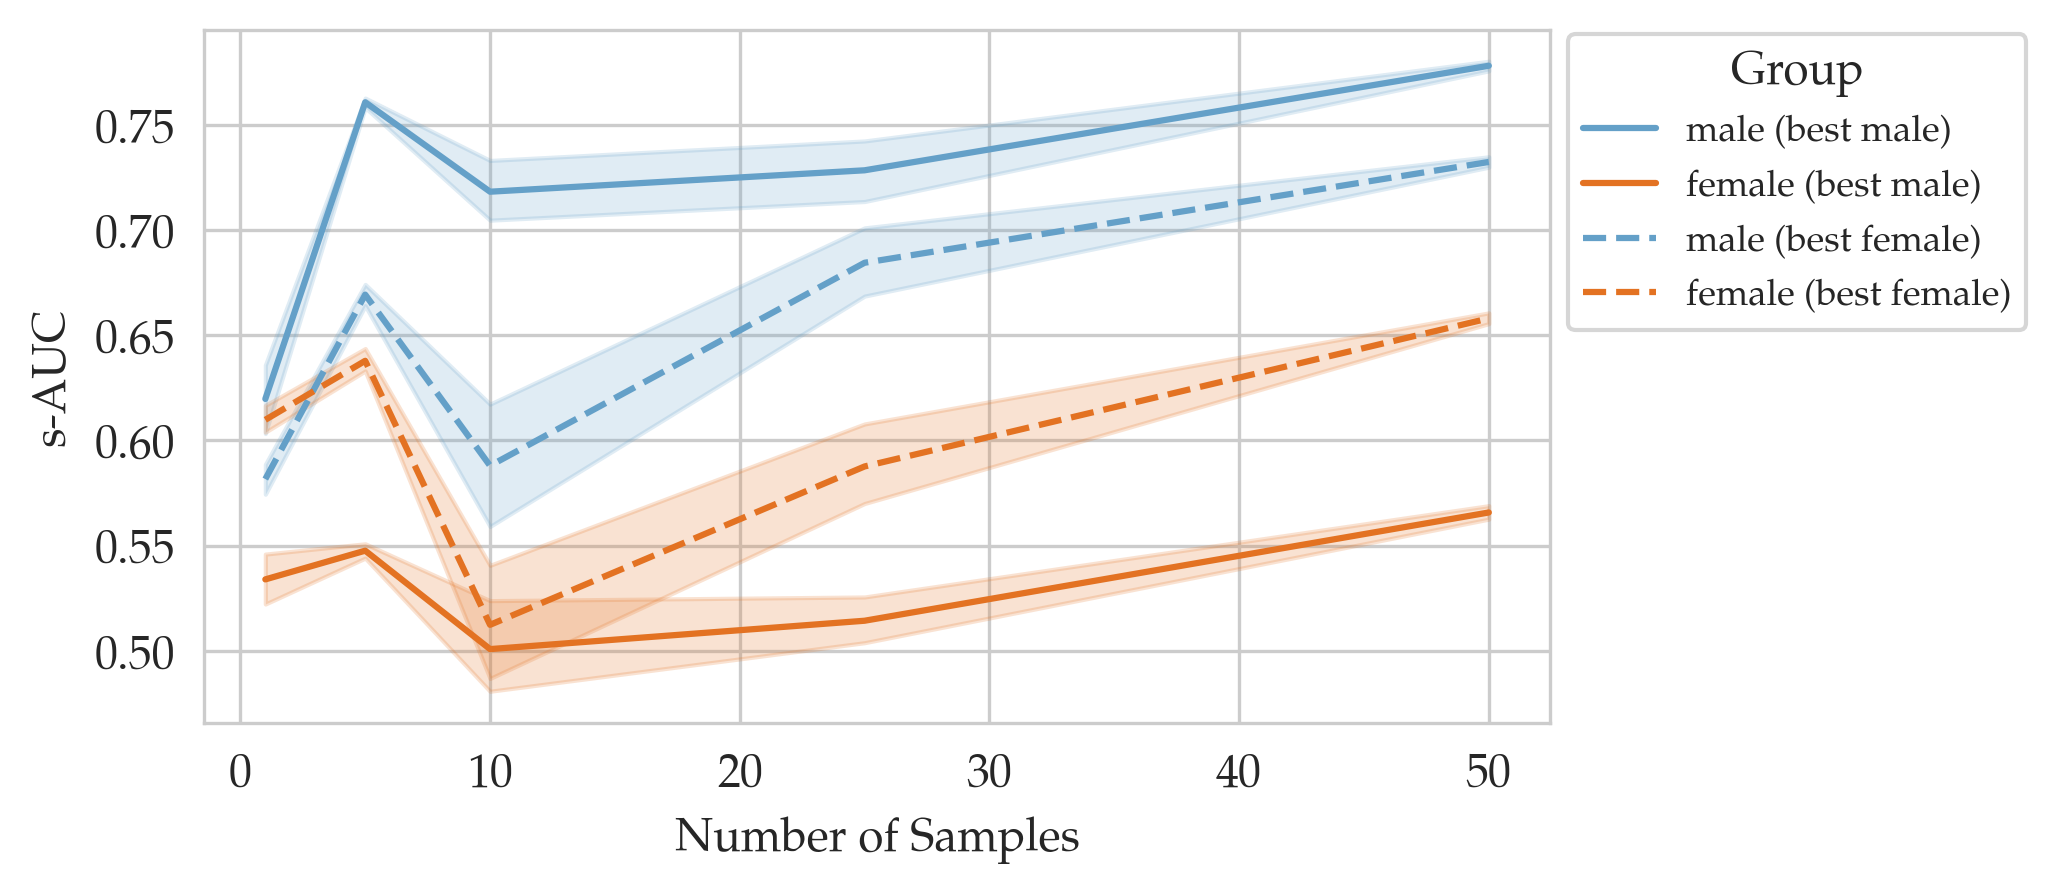

In [117]:
plot_coresetselection(data_noDP)

# DP

In [118]:
data_DP = data_DP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_DP = data_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")

In [119]:
data_DP = data_DP.loc[data_DP["score_var"] != "AUROC"]
data_DP.metric = data_DP.metric.str.replace("test/", "")
data_DP.metric = data_DP.metric.str.replace("_subgroupAUROC", "")

old_subgroupAUROC
mean old-AUC: 0.4901791860659917 std old-AUC: 0.05071530699532676
old_subgroupAUROC
mean young-AUC: 0.4648666630188624 std young-AUC: 0.06542324764857278
young_subgroupAUROC
mean old-AUC: 0.47079583009084064 std old-AUC: 0.04773656900737258
young_subgroupAUROC
mean young-AUC: 0.5172083477179209 std young-AUC: 0.05156663244757579


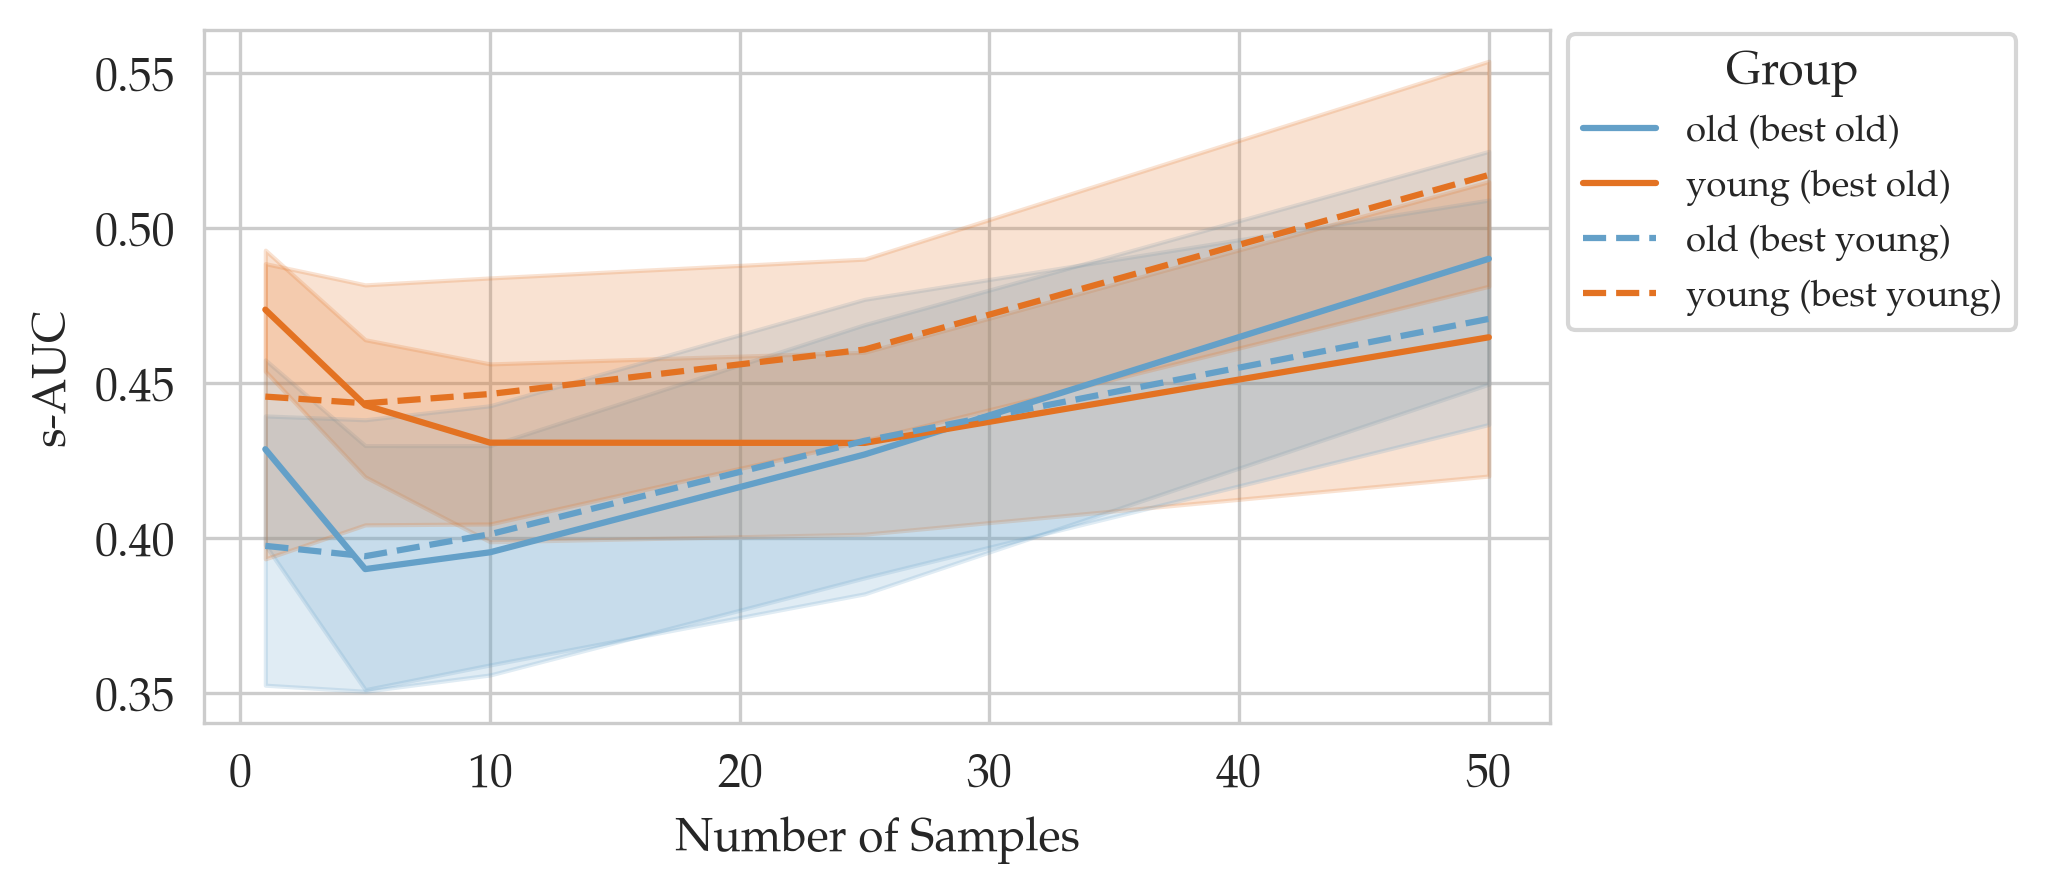

male_subgroupAUROC
mean male-AUC: 0.5494291683038076 std male-AUC: 0.05220377303267518
male_subgroupAUROC
mean female-AUC: 0.42279167970021564 std female-AUC: 0.061200871702559806
female_subgroupAUROC
mean male-AUC: 0.5190416524807612 std male-AUC: 0.055305265332528955
female_subgroupAUROC
mean female-AUC: 0.4682166775067647 std female-AUC: 0.05763776373108449


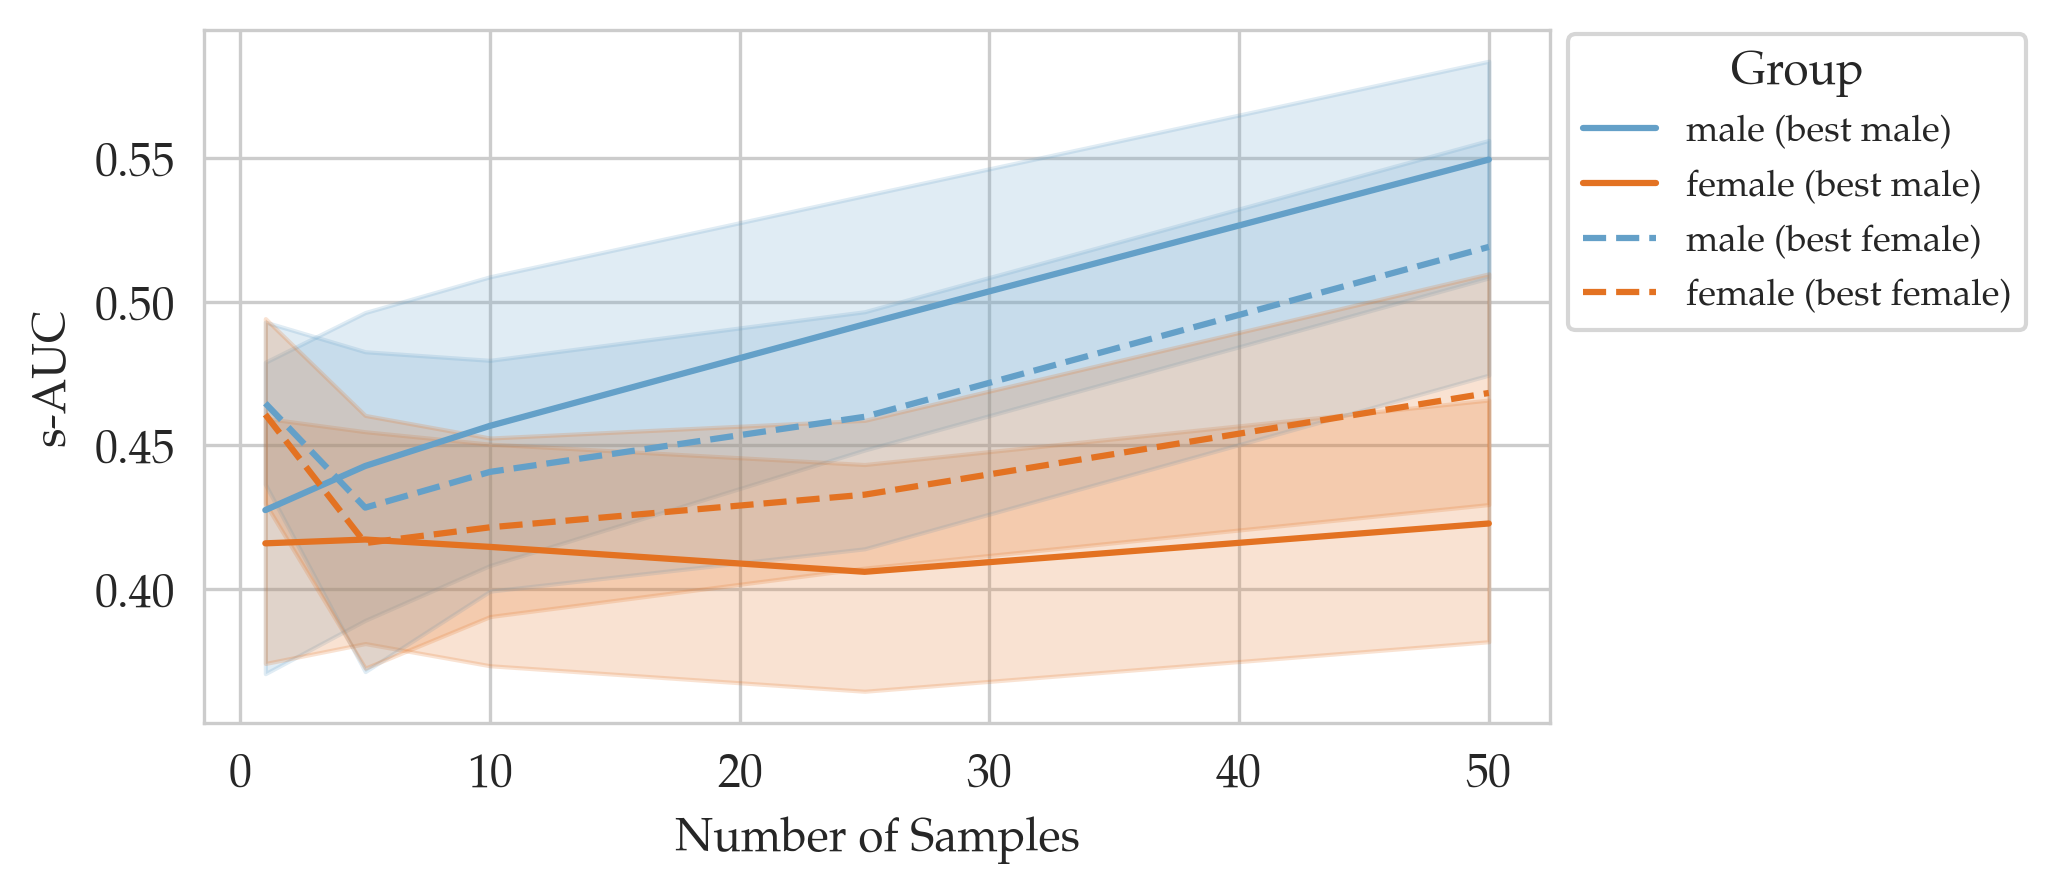

In [120]:
plot_coresetselection(data_DP, dp=True)

In [121]:
metrics_age = [f"test/old_subgroupAUROC", f"test/young_subgroupAUROC"]
metrics_sex = [f"test/female_subgroupAUROC", f"test/male_subgroupAUROC"]
data_age_DP.columns = [col.replace("lungOpacity_", "") for col in data_age_DP.columns]
data_sex_DP.columns = [col.replace("lungOpacity_", "") for col in data_sex_DP.columns]

In [122]:
data_age_DP = data_age_DP[[*metrics_age, "dataset", "seed", "score_var","num_samples"]]
data_sex_DP = data_sex_DP[[*metrics_sex, "dataset", "seed", "score_var","num_samples"]]
data_age_DP = data_age_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")
data_sex_DP = data_sex_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="metric", value_name="value")
data_DP = pd.concat([data_age_DP,data_sex_DP], ignore_index=True, axis=0)

In [123]:
data_DP = data_DP.loc[data_DP["score_var"] != "AUROC"]
data_DP.metric = data_DP.metric.str.replace("test/", "")
data_DP.metric = data_DP.metric.str.replace("_subgroupAUROC", "")

old_subgroupAUROC
mean old-AUC: 0.6465600252151489 std old-AUC: 0.04485161174999188
old_subgroupAUROC
mean young-AUC: 0.5671600103378296 std young-AUC: 0.033782687561671666
young_subgroupAUROC
mean old-AUC: 0.6118000149726868 std old-AUC: 0.042477050553377846
young_subgroupAUROC
mean young-AUC: 0.5735999822616578 std young-AUC: 0.03205491119287781


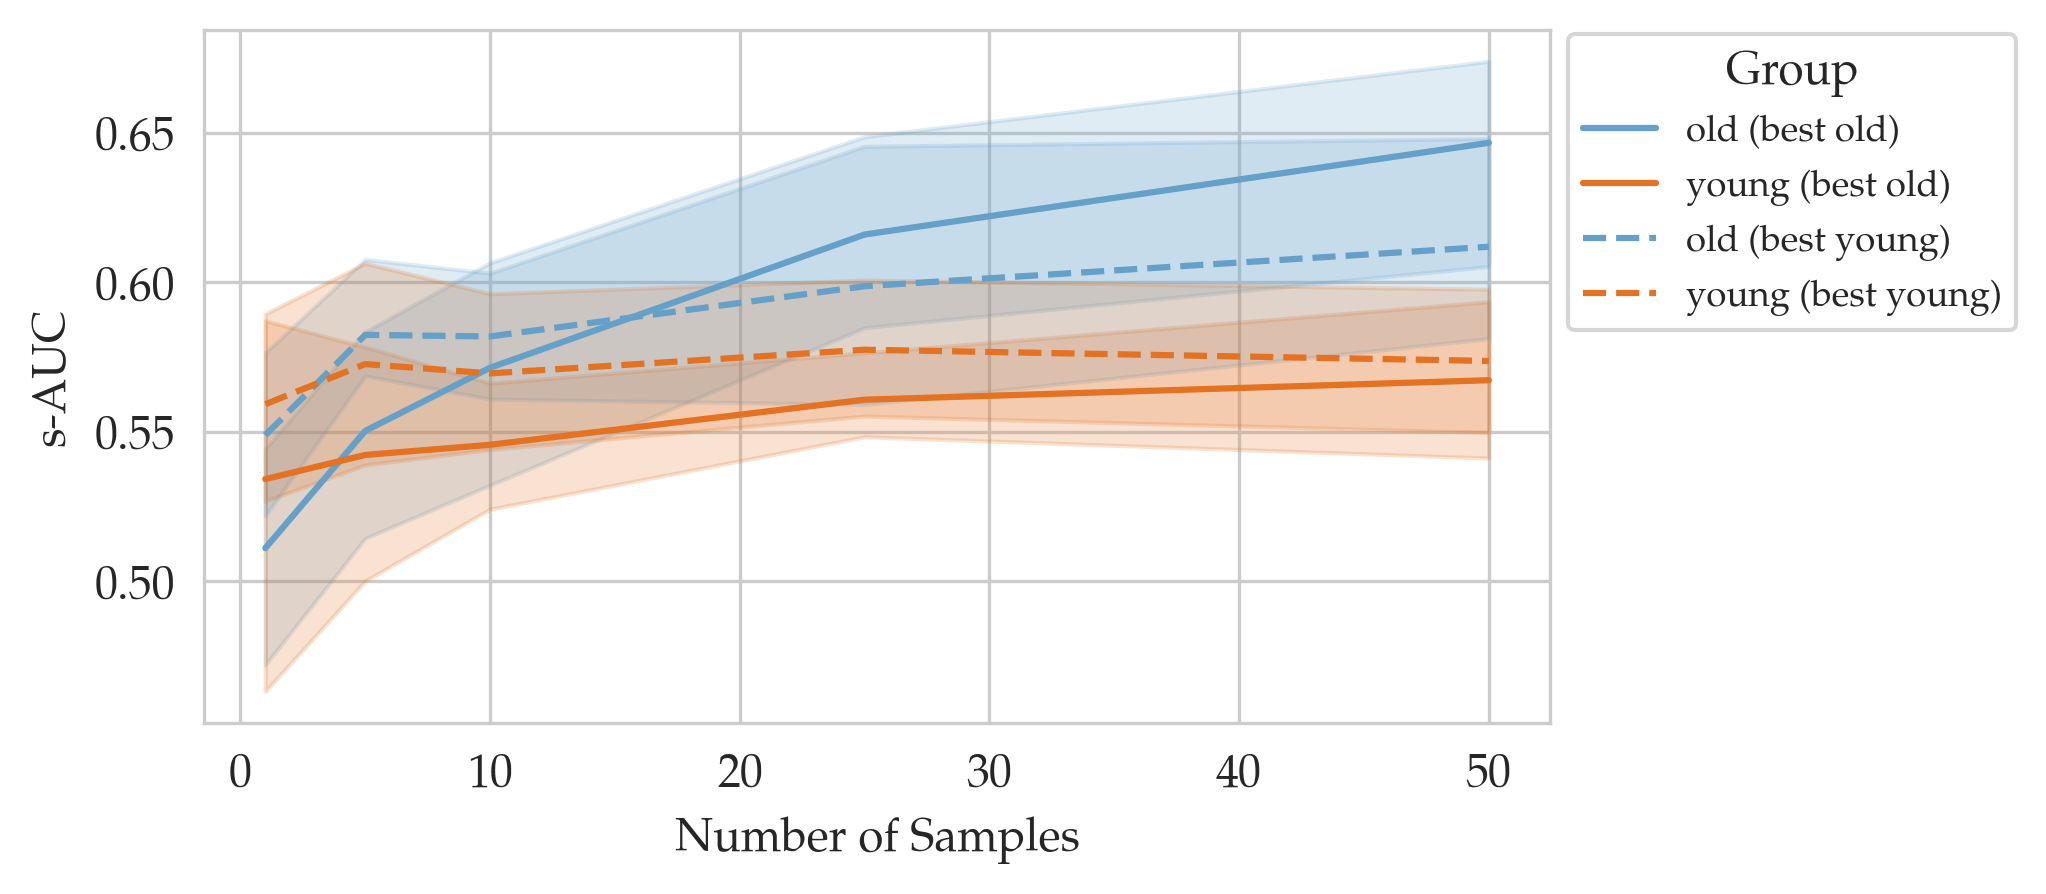

male_subgroupAUROC
mean male-AUC: 0.6151999950408935 std male-AUC: 0.028271198003605023
male_subgroupAUROC
mean female-AUC: 0.5040799796581268 std female-AUC: 0.03618358991476771
female_subgroupAUROC
mean male-AUC: 0.6195599794387817 std male-AUC: 0.03882613770748545
female_subgroupAUROC
mean female-AUC: 0.5052000105381012 std female-AUC: 0.031348699009910594


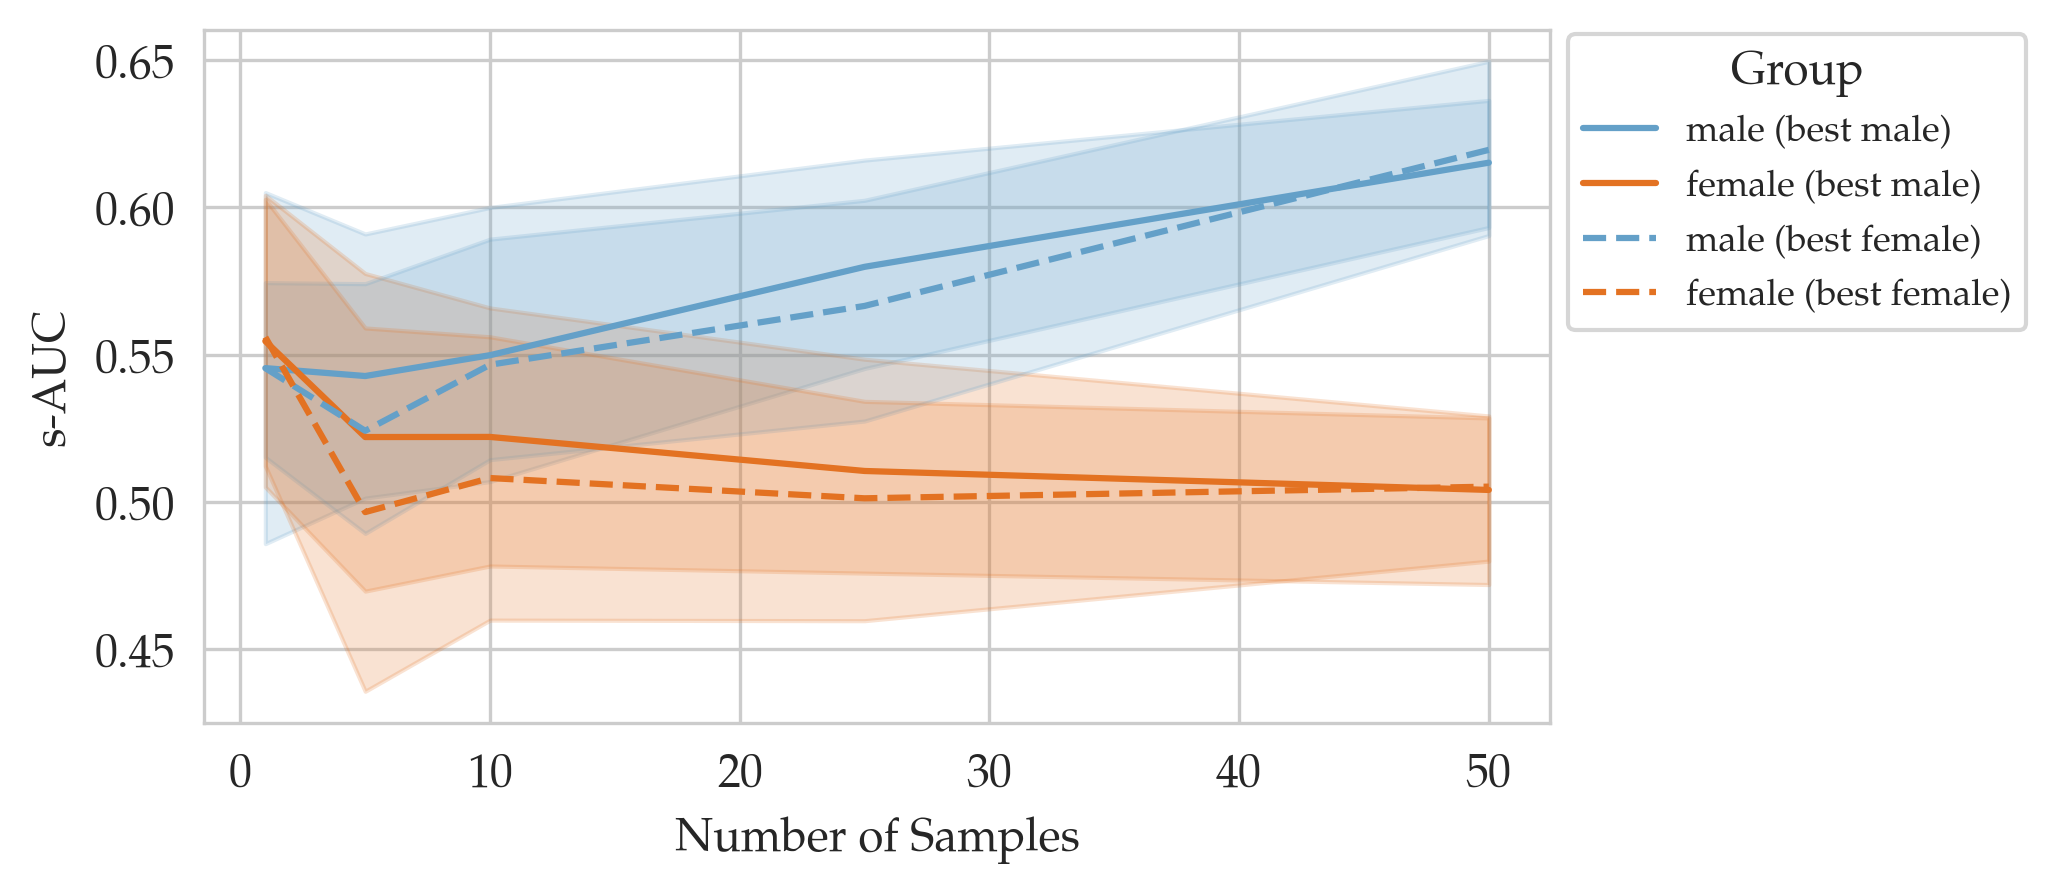

In [124]:
plot_coresetselection(data_DP, dp=True)